# Imports

In [31]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel
import torch
import umap
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings

In [32]:
warnings.filterwarnings('ignore')

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [24]:
cluster_name_map = {}  # Will store cluster ID to name mappings

# Pipeline creation

## Data Loading and EDA

In [6]:
# ======================
# 1. Data Loading & EDA
# ======================

def load_data(file_path):
    """
    Load text data from pickle file and convert to DataFrame
    
    Args:
        file_path (str): Path to pickle file containing text data
        
    Returns:
        pd.DataFrame: DataFrame with 'document' column containing text
    """
    texts = pickle.load(open(file_path, 'rb'))
    df = pd.DataFrame({'document': texts})
    return df

def basic_eda(df):
    """
    Perform basic exploratory data analysis on text data
    
    Args:
        df (pd.DataFrame): DataFrame containing text data
        
    Returns:
        pd.DataFrame: Processed DataFrame with additional metrics
    """
    print("Number of documents:", len(df))
    print("\nSample documents:")
    print(df['document'].head(2))
    
    # Remove empty documents
    df['length'] = df['document'].apply(lambda x: len(x.strip()))
    df = df[df['length'] > 0]
    print("\nNumber of non-empty documents:", len(df))
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print("\nNumber of duplicate documents:", duplicates)
    
    return df

In [7]:
def plot_document_length_distribution(df):
    """
    Plot distribution of word counts in documents
    
    Args:
        df (pd.DataFrame): DataFrame containing text data
    """
    df['word_count'] = df['document'].apply(lambda x: len(word_tokenize(x)))
    plt.figure(figsize=(10, 5))
    sns.histplot(df['word_count'], bins=30, kde=True)
    plt.title('Distribution of Word Count per Document')
    plt.xlabel('Word Count')
    plt.ylabel('Number of Documents')
    plt.show()

## Pre-Processing of Dataset

In [36]:
def preprocess(doc):
    """
    Clean and tokenize a text document
    
    Args:
        doc (str): Input text document
        
    Returns:
        list: List of cleaned and lemmatized tokens
    """
    doc = doc.lower()
    doc = re.sub(r"[^a-zA-Z\s]", "", doc)  # Remove non-alphabetic characters
    tokens = word_tokenize(doc)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens 
              if word not in stop_words and len(word) > 2]
    return tokens

def preprocess_dataframe(df):
    """
    Preprocess all documents in DataFrame and add cleaned text column
    
    Args:
        df (pd.DataFrame): DataFrame containing raw text data
        
    Returns:
        pd.DataFrame: DataFrame with added 'clean_text' column
    """
    token_lists = df['document'].apply(preprocess)
    df['clean_text'] = token_lists.apply(lambda tokens: ' '.join(tokens))
    return df

In [9]:
def visualize_word_frequencies(df):
    """
    Generate visualizations of word frequencies (top words and word cloud)
    
    Args:
        df (pd.DataFrame): DataFrame containing cleaned text data
    """
    # Flatten all tokens
    token_lists = df['document'].apply(preprocess)
    all_tokens = [token for sublist in token_lists for token in sublist]
    
    # Show example processed texts
    print("\nExample preprocessed documents:")
    print(token_lists.head(2))
    
    # Plot top 30 most frequent words
    common_words = Counter(all_tokens).most_common(30)
    words, freqs = zip(*common_words)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(freqs), y=list(words))
    plt.title("Top 30 Most Common Words")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.show()
    
    # WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Frequent Words in Corpus")
    plt.show()

## Feature Extraction

In [11]:
# ======================
# 3. Feature Extraction
# ======================

def extract_tfidf_features(df, max_features=10000):
    """
    Extract TF-IDF features from cleaned text
    
    Args:
        df (pd.DataFrame): DataFrame containing cleaned text
        max_features (int): Maximum number of features to keep
        
    Returns:
        scipy.sparse.csr_matrix: TF-IDF feature matrix
        TfidfVectorizer: Fitted vectorizer object
    """
    vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, max_features=max_features)
    X_tfidf = vectorizer.fit_transform(df['clean_text'])
    print("\nTF-IDF matrix shape:", X_tfidf.shape)
    return X_tfidf, vectorizer

def reduce_dimensionality(X_tfidf, n_components=100):
    """
    Reduce dimensionality using Truncated SVD (LSA)
    
    Args:
        X_tfidf: TF-IDF feature matrix
        n_components (int): Number of dimensions to keep
        
    Returns:
        numpy.ndarray: Reduced feature matrix
        TruncatedSVD: Fitted SVD object
    """
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    
    X_lsa = lsa.fit_transform(X_tfidf)
    print("LSA-reduced feature matrix shape:", X_lsa.shape)
    
    # Explained variance
    explained_variance = svd.explained_variance_ratio_.sum()
    print("\nTotal explained variance by {} components: {}".format(
        n_components, round(explained_variance, 4)))
    
    # Plot explained variance
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='o')
    plt.title('Cumulative Explained Variance by LSA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()
    
    return X_lsa, svd

## Clustering

In [12]:
# ======================
# 4. Clustering
# ======================

def perform_clustering(X_lsa, n_clusters=5):
    """
    Perform KMeans clustering and evaluate results
    
    Args:
        X_lsa: Reduced feature matrix
        n_clusters (int): Number of clusters to create
        
    Returns:
        np.ndarray: Cluster labels
    """
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    y_kmeans = kmeans.fit_predict(X_lsa)
    
    # Apply Agglomerative Clustering
    auto_agglom = AgglomerativeClustering(n_clusters=n_clusters)
    y_agglom = auto_agglom.fit_predict(X_lsa)
    
    # Compute clustering metrics
    print("\nKMeans Silhouette Score:", silhouette_score(X_lsa, y_kmeans))
    print("KMeans Davies-Bouldin Index:", davies_bouldin_score(X_lsa, y_kmeans))
    print("Agglomerative Silhouette Score:", silhouette_score(X_lsa, y_agglom))
    print("Agglomerative Davies-Bouldin Index:", davies_bouldin_score(X_lsa, y_agglom))
    
    return y_kmeans

def visualize_clusters(X_lsa, cluster_labels, method='PCA'):
    """
    Visualize clusters using dimensionality reduction
    
    Args:
        X_lsa: Reduced feature matrix
        cluster_labels: Array of cluster assignments
        method (str): Visualization method ('PCA', 'TSNE', or 'UMAP')
    """
    if method == 'PCA':
        reducer = PCA(n_components=2)
        title = "Clusters Visualized with PCA"
    elif method == 'TSNE':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        title = "Clusters Visualized with t-SNE"
    elif method == 'UMAP':
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
        title = "Clusters Visualized with UMAP"
    
    x_reduced = reducer.fit_transform(X_lsa)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=cluster_labels, 
                cmap='tab10' if method == 'UMAP' else 'Set1', s=10)
    plt.title(title)
    plt.xlabel(f"{method} Component 1")
    plt.ylabel(f"{method} Component 2")
    plt.show()



In [13]:
def analyze_clusters(df, X_tfidf, vectorizer, cluster_labels, n_clusters=5):
    """
    Analyze and label clusters based on top terms
    
    Args:
        df (pd.DataFrame): DataFrame containing text data
        X_tfidf: TF-IDF feature matrix
        vectorizer: Fitted TF-IDF vectorizer
        cluster_labels: Array of cluster assignments
        n_clusters (int): Number of clusters
        
    Returns:
        dict: Mapping of cluster IDs to top terms
    """
    global cluster_name_map
    
    X_tfidf_array = X_tfidf.toarray()
    feature_names = vectorizer.get_feature_names_out()
    
    cluster_keywords = {}
    print("\nTop Terms Per Cluster:")
    
    for cluster in range(n_clusters):
        # Get indices of documents in this cluster
        indices = df[df['pseudo_label'] == cluster].index
        
        # Calculate average TF-IDF scores for cluster
        cluster_vecs = X_tfidf_array[indices]
        avg_tfidf = np.mean(cluster_vecs, axis=0)
        
        # Get top 10 words with highest average TF-IDF
        top_indices = avg_tfidf.argsort()[-10:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        cluster_keywords[cluster] = top_words
        
        # Create readable label from top 3 words
        readable_label = ' / '.join(top_words[:3])
        print(f"Cluster {cluster} (aka '{readable_label}') Top Words:", ', '.join(top_words))
        
        # Add cluster label to DataFrame
        df.loc[df['pseudo_label'] == cluster, 'cluster_label'] = readable_label
    
    # Assign single-word cluster names
    for cluster, keywords in cluster_keywords.items():
        topic_name = keywords[0] if keywords else 'Unknown'
        cluster_name_map[cluster] = topic_name
    
    # Add cluster names to DataFrame
    df['cluster_name'] = df['pseudo_label'].map(cluster_name_map)
    
    print("\nAssigned Cluster Names:")
    for cluster, name in cluster_name_map.items():
        print(f"Cluster {cluster}: {name}")
    
    # Show sample documents per cluster
    print("\nSample Documents Per Cluster:")
    for cluster in range(n_clusters):
        print(f"--- Cluster {cluster} ({cluster_name_map[cluster]}) ---")
        samples = df[df['pseudo_label'] == cluster]['document'].sample(n=2, random_state=cluster).values
        for doc in samples:
            print(f"• {doc[:200]}...")
    
    return cluster_keywords

def plot_cluster_distribution(df):
    """
    Plot distribution of documents across clusters
    
    Args:
        df (pd.DataFrame): DataFrame with cluster assignments
    """
    plt.figure(figsize=(6,4))
    df['cluster_name'].value_counts().reindex(list(cluster_name_map.values())).plot(
        kind='bar', color='skyblue')
    plt.title('Cluster Name Distribution')
    plt.xlabel('Cluster Name')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

In [14]:
# ======================
# 5. Classification
# ======================

def prepare_classification_data(X_lsa, df):
    """
    Split data into train/test sets for classification
    
    Args:
        X_lsa: Reduced feature matrix
        df (pd.DataFrame): DataFrame with cluster labels
        
    Returns:
        tuple: (X_train, X_test, y_train, y_test)
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X_lsa, df['pseudo_label'], test_size=0.2, random_state=42, 
        stratify=df['pseudo_label'])
    return X_train, X_test, y_train, y_test



In [15]:
def balance_data_with_smote(X_train, y_train):
    """
    Balance training data using SMOTE oversampling
    
    Args:
        X_train: Training features
        y_train: Training labels
        
    Returns:
        tuple: Balanced (X_train, y_train)
    """
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    
    print("\nBalanced label distribution after SMOTE:")
    print(pd.Series(y_train_bal).value_counts())
    
    # Visualize balanced distribution
    plt.figure(figsize=(6,4))
    pd.Series(y_train_bal).map(cluster_name_map).value_counts().reindex(
        list(cluster_name_map.values())).plot(kind='bar', color='lightgreen')
    plt.title('Balanced Cluster Name Distribution After SMOTE')
    plt.xlabel('Cluster Name')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()
    
    return X_train_bal, y_train_bal


In [16]:
def train_classifiers(X_train, y_train):
    """
    Train and tune multiple classifiers
    
    Args:
        X_train: Training features
        y_train: Training labels
        
    Returns:
        dict: Dictionary of trained models
    """
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': SVC(random_state=42)
    }
    
    # Tune Random Forest
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
    }
    rf_grid = GridSearchCV(models['Random Forest'], param_grid_rf, cv=3, scoring='f1_macro')
    rf_grid.fit(X_train, y_train)
    best_rf = rf_grid.best_estimator_
    
    # Tune Logistic Regression
    param_grid_lr = {
        'C': [0.1, 1.0, 10.0]
    }
    lr_grid = GridSearchCV(models['Logistic Regression'], param_grid_lr, cv=3, scoring='f1_macro')
    lr_grid.fit(X_train, y_train)
    best_lr = lr_grid.best_estimator_
    
    # Tune SVM
    param_grid_svm = {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'rbf']
    }
    svm_grid = GridSearchCV(models['SVM'], param_grid_svm, cv=3, scoring='f1_macro')
    svm_grid.fit(X_train, y_train)
    best_svm = svm_grid.best_estimator_
    
    return {
        'Random Forest': best_rf,
        'Logistic Regression': best_lr,
        'SVM': best_svm
    }


In [20]:
def evaluate_classifiers(models, X_test, y_test):
    """
    Evaluate classifiers and generate reports
    
    Args:
        models (dict): Dictionary of trained models
        X_test: Test features
        y_test: Test labels
    """
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred, 
                                   target_names=[cluster_name_map[i] for i in sorted(set(y_test))]))
        
        # Confusion matrix
        labels = sorted(set(y_test))
        label_names = [cluster_name_map[label] for label in labels]
        plt.figure(figsize=(8,6))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', 
                    cmap='Blues', xticklabels=label_names, yticklabels=label_names)
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

def compare_model_performance(models, X_test, y_test):
    """
    Compare model performance visually
    
    Args:
        models (dict): Dictionary of trained models
        X_test: Test features
        y_test: Test labels
    """
    # Calculate metrics
    model_names = list(models.keys())
    accuracy_values = [accuracy_score(y_test, model.predict(X_test)) for model in models.values()]
    macro_f1_values = [f1_score(y_test, model.predict(X_test), average='macro') for model in models.values()]
    
    best_index = np.argmax(macro_f1_values)
    best_model_name = model_names[best_index]
    best_model_object = models[best_model_name]
    
    print(f"Best performing model based on Macro F1: {best_model_name}")
    
    # Create bar chart
    x = range(len(model_names))
    bar_width = 0.35
    
    plt.figure(figsize=(12, 6))
    plt.bar(x, accuracy_values, width=bar_width, label='Accuracy', color='steelblue')
    plt.bar([i + bar_width for i in x], macro_f1_values, width=bar_width, label='Macro F1', color='orange')
    
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Model Comparison: Accuracy vs Macro F1')
    plt.xticks([i + bar_width / 2 for i in x], model_names, rotation=30, ha='right')
    plt.ylim(0.7, 1.0)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    return best_model_name, best_model_object


## Advanced Embeddings

In [18]:
# ======================
# 6. Advanced Embeddings
# ======================

def generate_sbert_embeddings(texts):
    """
    Generate SBERT embeddings for text
    
    Args:
        texts (list): List of text documents
        
    Returns:
        numpy.ndarray: SBERT embeddings
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(texts, show_progress_bar=True)
    return embeddings

def generate_bert_embeddings(texts):
    """
    Generate BERT embeddings for text
    
    Args:
        texts (list): List of text documents
        
    Returns:
        numpy.ndarray: BERT embeddings
    """
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()
    
    embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors='pt', truncation=True, 
                             padding=True, max_length=512)
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_embedding)
    
    return np.vstack(embeddings)

def evaluate_embeddings(X_emb, y_true, embedding_name):
    """
    Evaluate clustering and classification performance on embeddings
    
    Args:
        X_emb: Embedding matrix
        y_true: True cluster labels
        embedding_name (str): Name of embedding method
    """
    # Clustering evaluation
    kmeans = KMeans(n_clusters=5, random_state=42)
    y_pred = kmeans.fit_predict(X_emb)
    print(f"\n{embedding_name} Clustering Silhouette Score:", silhouette_score(X_emb, y_pred))
    
    # Visualization
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    x_umap = reducer.fit_transform(X_emb)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(x_umap[:, 0], x_umap[:, 1], c=y_pred, cmap='tab10', s=10)
    plt.title(f"{embedding_name} Clusters Visualized with UMAP")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()
    
    # Classification evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X_emb, y_true, test_size=0.2, random_state=42, stratify=y_true)
    
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{embedding_name} Classification Report:")
    print(classification_report(y_test, y_pred, 
                               target_names=[cluster_name_map[i] for i in sorted(set(y_test))]))
    
    # Confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', 
                cmap='Blues' if 'SBERT' in embedding_name else 'Oranges')
    plt.title(f'{embedding_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


## Main Pipeline

In [21]:
# ======================
# 7. Main Pipeline
# ======================

def run_text_analysis_pipeline(file_path, n_clusters=5):
    """
    Main function to run the entire text analysis pipeline
    
    Args:
        file_path (str): Path to input text data file
        n_clusters (int): Number of clusters to create
    """
    # 1. Load and explore data
    print("\n=== Loading and Exploring Data ===")
    df = load_data(file_path)
    df = basic_eda(df)
    plot_document_length_distribution(df)
    
    # 2. Preprocess text
    print("\n=== Preprocessing Text ===")
    df = preprocess_dataframe(df)
    visualize_word_frequencies(df)
    
    # 3. Feature extraction
    print("\n=== Feature Extraction ===")
    X_tfidf, vectorizer = extract_tfidf_features(df)
    X_lsa, svd = reduce_dimensionality(X_tfidf)
    
    # 4. Clustering
    print("\n=== Clustering ===")
    cluster_labels = perform_clustering(X_lsa, n_clusters)
    df['pseudo_label'] = cluster_labels
    
    # Visualize clusters
    visualize_clusters(X_lsa, cluster_labels, method='PCA')
    visualize_clusters(X_lsa, cluster_labels, method='TSNE')
    visualize_clusters(X_lsa, cluster_labels, method='UMAP')
    
    # Analyze and label clusters
    cluster_keywords = analyze_clusters(df, X_tfidf, vectorizer, cluster_labels, n_clusters)
    plot_cluster_distribution(df)
    
    # 5. Classification
    print("\n=== Classification ===")
    X_train, X_test, y_train, y_test = prepare_classification_data(X_lsa, df)
    X_train_bal, y_train_bal = balance_data_with_smote(X_train, y_train)
    
    # Train and evaluate classifiers
    models = train_classifiers(X_train_bal, y_train_bal)
    evaluate_classifiers(models, X_test, y_test)
    best_model_name, best_model = compare_model_performance(models, X_test, y_test)
    
    # 6. Advanced embeddings
    print("\n=== Evaluating Advanced Embeddings ===")
    print("Generating SBERT embeddings...")
    X_sbert = generate_sbert_embeddings(df['clean_text'])
    evaluate_embeddings(X_sbert, df['pseudo_label'], "SBERT")
    
    print("Generating BERT embeddings...")
    X_bert = generate_bert_embeddings(df['clean_text'])
    evaluate_embeddings(X_bert, df['pseudo_label'], "BERT")
    
    # 7. Save best model
    print("\n=== Saving Best Model ===")
    joblib.dump(best_model, 'final_best_model.pkl')
    joblib.dump(vectorizer, 'final_vectorizer.pkl')
    joblib.dump(svd, 'final_svd.pkl')
    print("Pipeline completed. Models saved.")


# Inference utils for model

In [28]:
def load_pipeline():
    """
    Load saved model pipeline components
    
    Returns:
        tuple: (model, vectorizer, svd) objects
    """
    model = joblib.load('final_best_model.pkl')
    vectorizer = joblib.load('final_vectorizer.pkl')
    svd = joblib.load('final_svd.pkl')
    return model, vectorizer, svd

def predict_from_text(text_list):
    """
    Make predictions on new text data
    
    Args:
        text_list (list): List of raw text documents to predict
        
    Returns:
        list: List of tuples (cluster_name, confidence)
    """
    model, vectorizer, svd = load_pipeline()
    
    # Preprocess text
    cleaned = [' '.join(preprocess(doc)) for doc in text_list]
    
    # Transform features
    X_tfidf = vectorizer.transform(cleaned)
    X_lsa = svd.transform(X_tfidf)
    
    # Make predictions
    probs = model.predict_proba(X_lsa)
    preds = model.predict(X_lsa)
    
    # Format results
    results = [(cluster_name_map[p], round(max(prob), 4)) for p, prob in zip(preds, probs)]
    return results

def predict_from_pickle(pkl_file):
    """
    Make predictions on documents from pickle file
    
    Args:
        pkl_file (str): Path to pickle file containing text documents
        
    Returns:
        list: List of prediction tuples (cluster_name, confidence)
    """
    texts = pickle.load(open(pkl_file, 'rb'))
    return predict_from_text(texts)

def predict_from_csv(csv_file, text_column):
    """
    Make predictions on documents from CSV file
    
    Args:
        csv_file (str): Path to CSV file
        text_column (str): Name of column containing text
        
    Returns:
        list: List of prediction tuples (cluster_name, confidence)
    """
    df = pd.read_csv(csv_file)
    texts = df[text_column].astype(str).tolist()
    return predict_from_text(texts)

# Example usage


=== Loading and Exploring Data ===
Number of documents: 1500

Sample documents:
0    \nIn article <93089.204431GRV101@psuvm.psu.edu...
1    \nIn article <1993Apr19.131102.7843@rchland.ib...
Name: document, dtype: object

Number of non-empty documents: 1500

Number of duplicate documents: 0


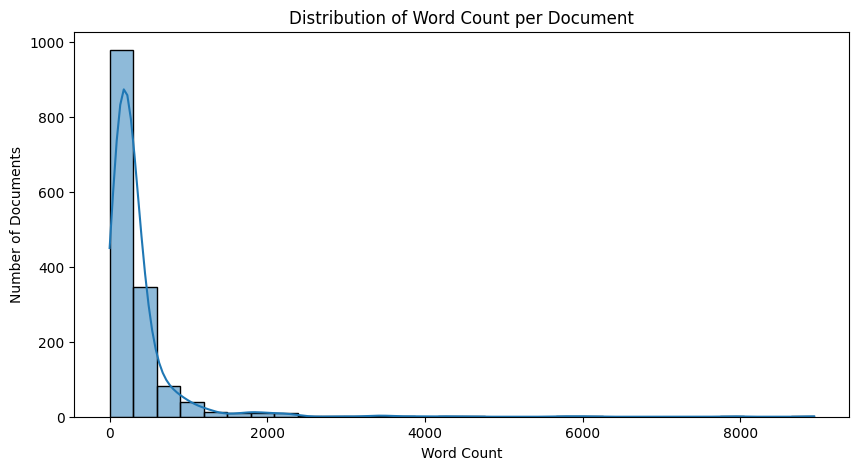


=== Preprocessing Text ===

Example preprocessed documents:
0    [article, grvpsuvmpsuedu, callec, dradja, grvp...
1    [article, aprrchlandibmcom, xzzrchlandvnetibmc...
Name: document, dtype: object


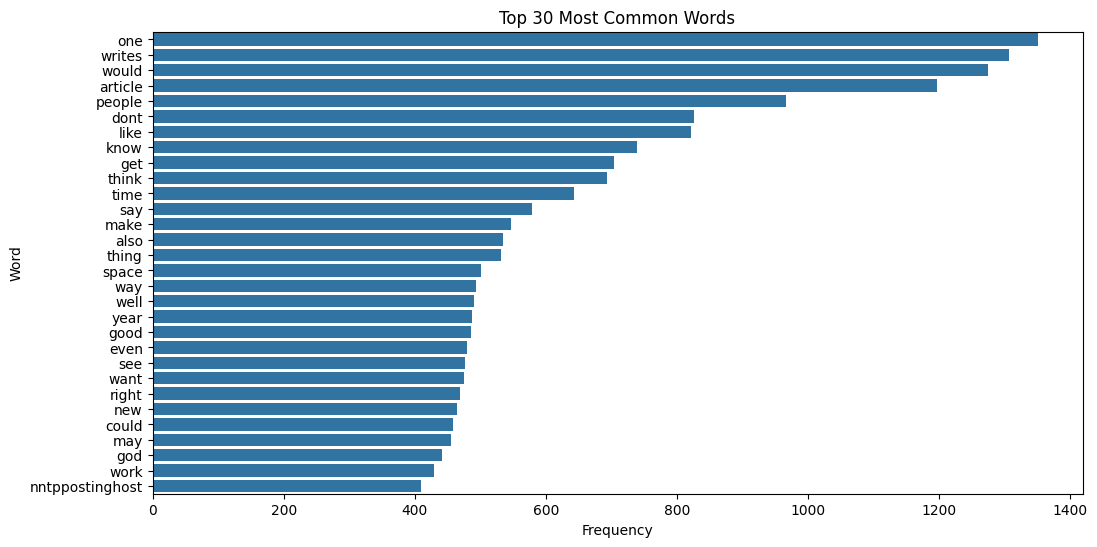

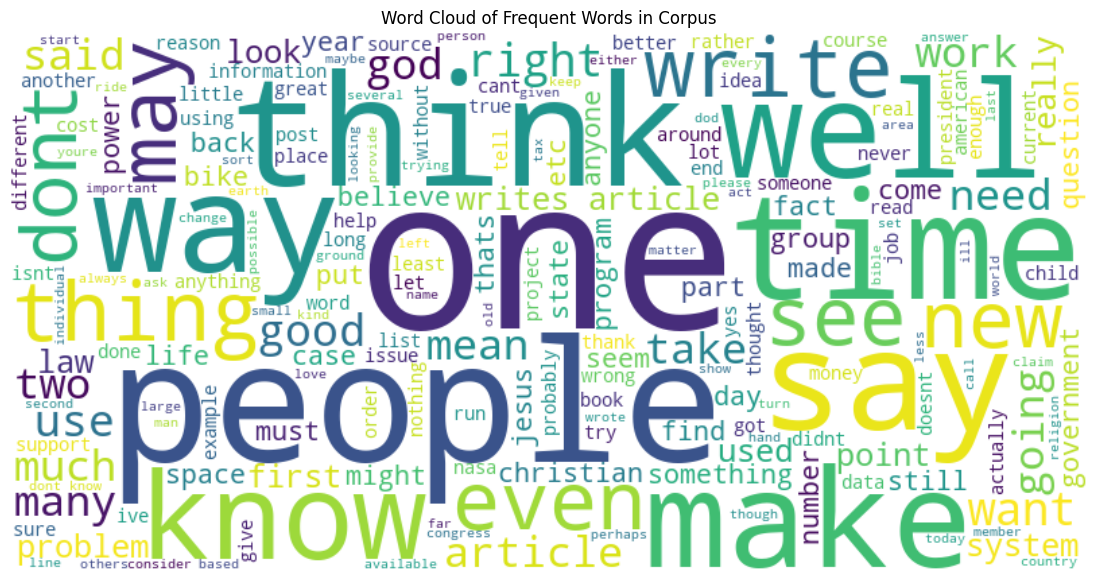


=== Feature Extraction ===

TF-IDF matrix shape: (1500, 5059)
LSA-reduced feature matrix shape: (1500, 100)

Total explained variance by 100 components: 0.2688


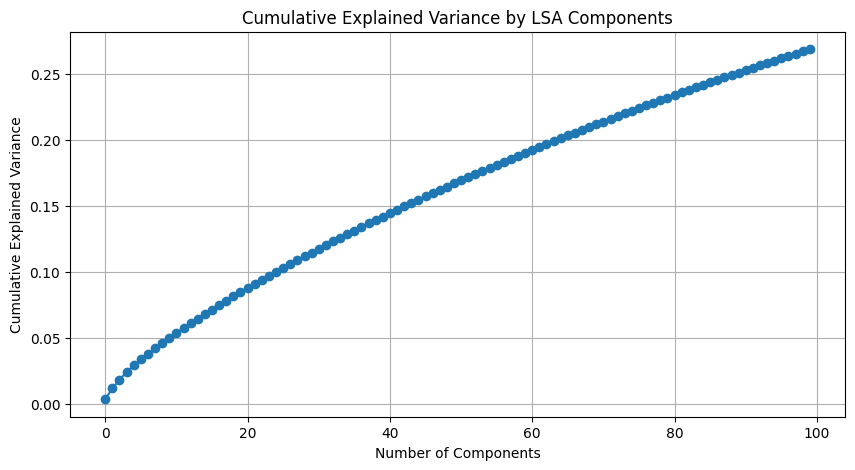


=== Clustering ===

KMeans Silhouette Score: 0.032796059084742
KMeans Davies-Bouldin Index: 5.0238863197989785
Agglomerative Silhouette Score: 0.02630247907787207
Agglomerative Davies-Bouldin Index: 5.520570268210857


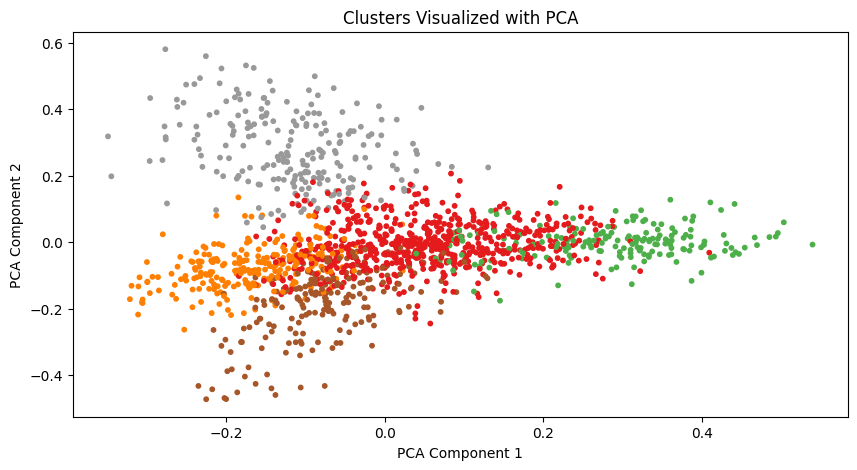

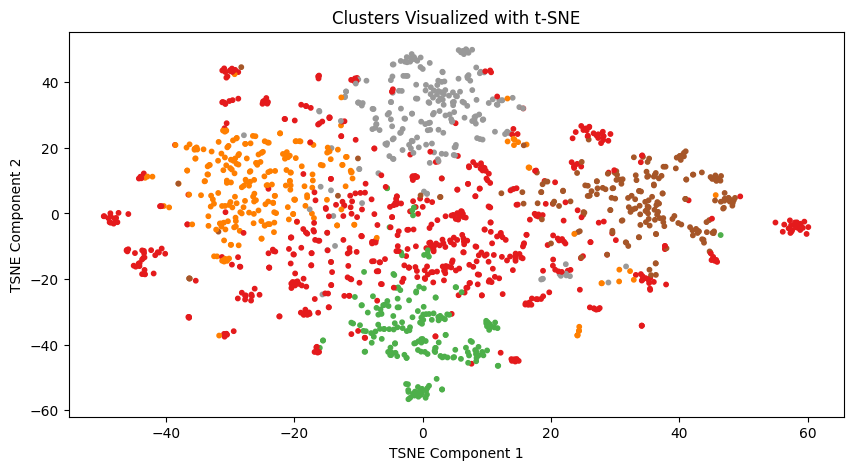

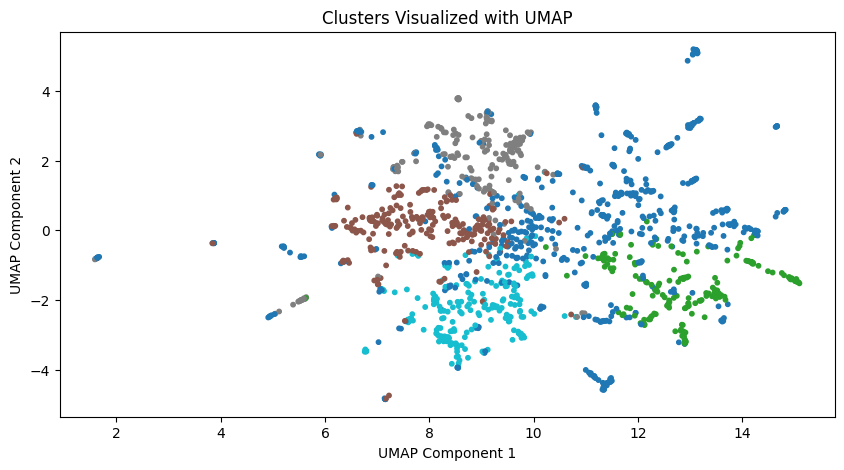


Top Terms Per Cluster:
Cluster 0 (aka 'writes / article / one') Top Words: writes, article, one, would, people, dont, nntppostinghost, government, get, like
Cluster 1 (aka 'god / jesus / christian') Top Words: god, jesus, christian, people, objective, would, one, bible, morality, christ
Cluster 2 (aka 'thanks / anyone / chip') Top Words: thanks, anyone, chip, circuit, know, would, use, one, email, line
Cluster 3 (aka 'space / moon / orbit') Top Words: space, moon, orbit, nasa, would, year, lunar, writes, flight, earth
Cluster 4 (aka 'bike / dod / dog') Top Words: bike, dod, dog, ride, motorcycle, riding, writes, article, rider, bmw

Assigned Cluster Names:
Cluster 0: writes
Cluster 1: god
Cluster 2: thanks
Cluster 3: space
Cluster 4: bike

Sample Documents Per Cluster:
--- Cluster 0 (writes) ---
• 

The article that follows was taken from the Wednesday, April 14, 1993
issue of USA Today ("Drug Use Up Among U.S. eighth-graders" by Mike
Snider, p. 6D).

    A new national survey says dr

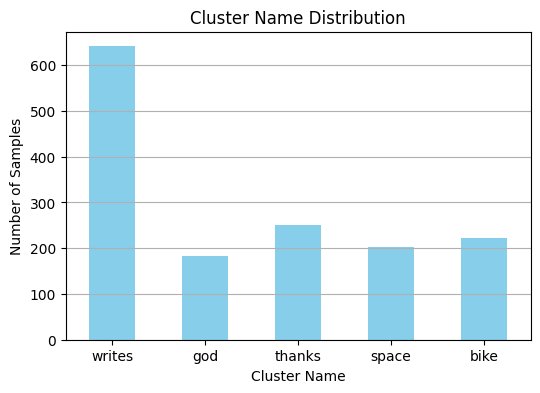


=== Classification ===

Balanced label distribution after SMOTE:
pseudo_label
3    513
2    513
0    513
4    513
1    513
Name: count, dtype: int64


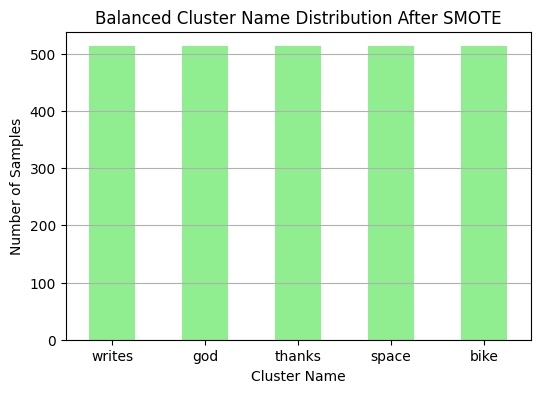


Random Forest Classification Report:
              precision    recall  f1-score   support

      writes       0.92      0.91      0.92       128
         god       0.92      0.95      0.93        37
      thanks       0.95      0.84      0.89        50
       space       0.85      0.98      0.91        41
        bike       0.98      0.98      0.98        44

    accuracy                           0.92       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.92      0.92       300



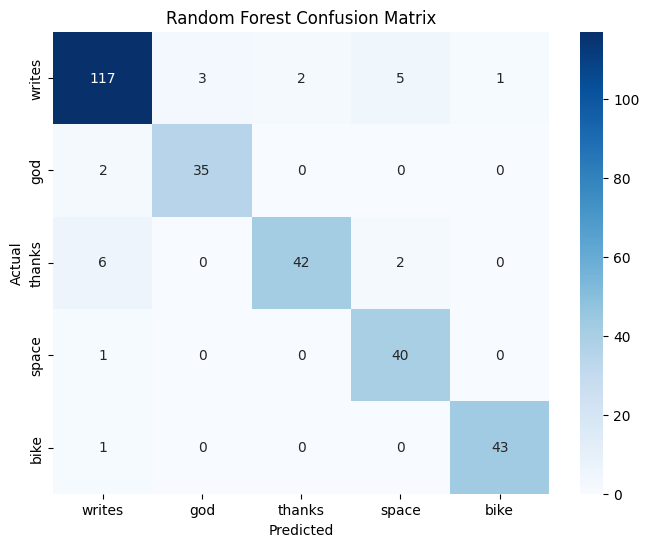


Logistic Regression Classification Report:
              precision    recall  f1-score   support

      writes       0.96      0.96      0.96       128
         god       0.97      0.97      0.97        37
      thanks       0.98      0.96      0.97        50
       space       0.93      0.95      0.94        41
        bike       0.95      0.95      0.95        44

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



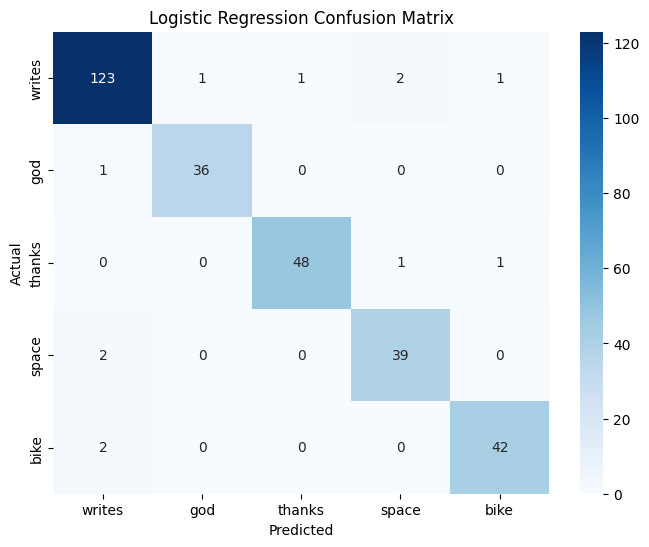


SVM Classification Report:
              precision    recall  f1-score   support

      writes       0.94      0.95      0.95       128
         god       1.00      0.95      0.97        37
      thanks       0.96      0.94      0.95        50
       space       0.88      0.93      0.90        41
        bike       0.98      0.95      0.97        44

    accuracy                           0.95       300
   macro avg       0.95      0.94      0.95       300
weighted avg       0.95      0.95      0.95       300



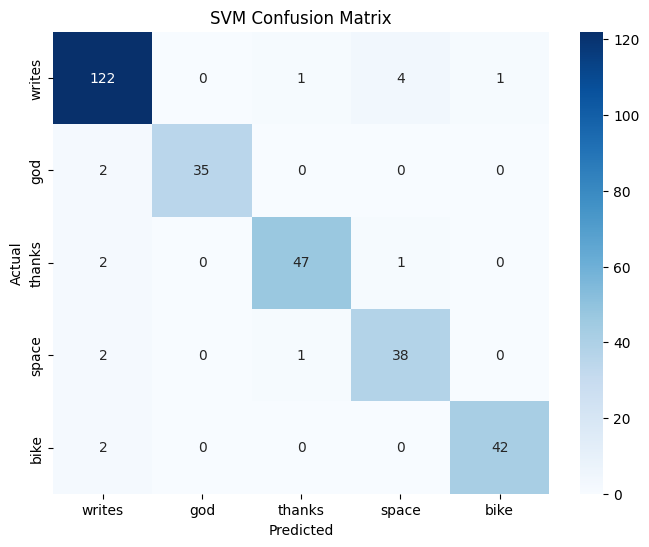

Best performing model based on Macro F1: Logistic Regression


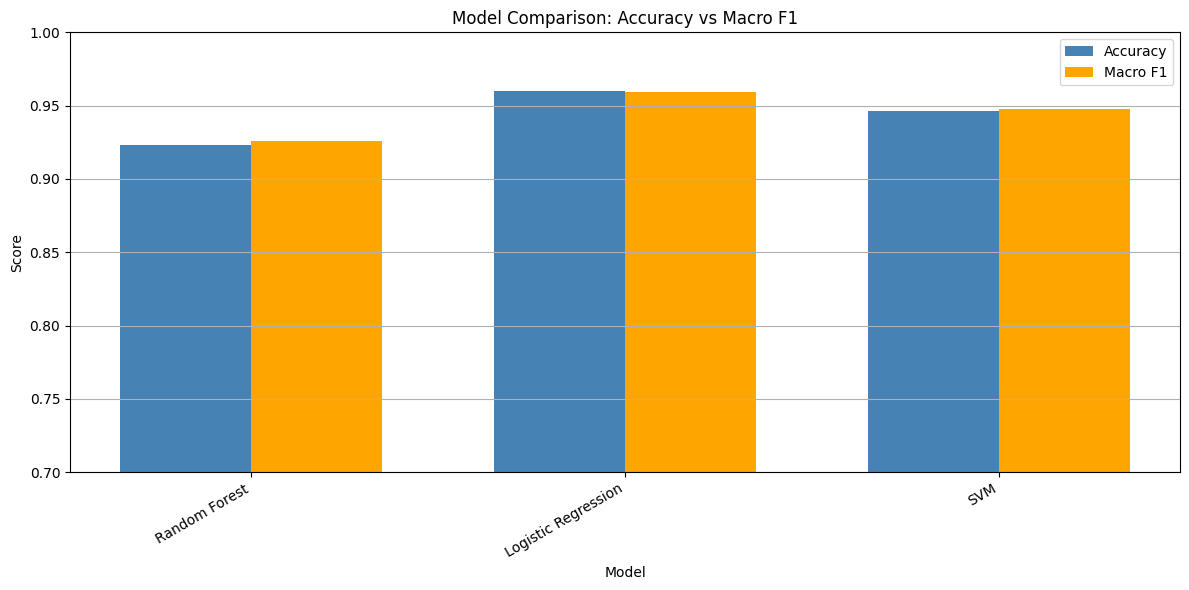


=== Evaluating Advanced Embeddings ===
Generating SBERT embeddings...


Batches: 100%|█████████████████████████████████████████████████████████████████████████| 47/47 [00:26<00:00,  1.78it/s]



SBERT Clustering Silhouette Score: 0.044496518


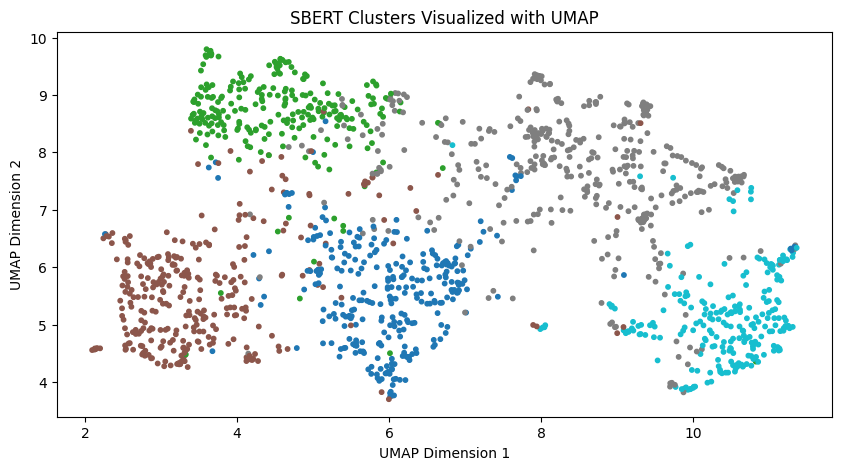


SBERT Classification Report:
              precision    recall  f1-score   support

      writes       0.79      0.84      0.81       128
         god       0.97      0.78      0.87        37
      thanks       0.82      0.74      0.78        50
       space       0.77      0.80      0.79        41
        bike       0.80      0.84      0.82        44

    accuracy                           0.81       300
   macro avg       0.83      0.80      0.81       300
weighted avg       0.81      0.81      0.81       300



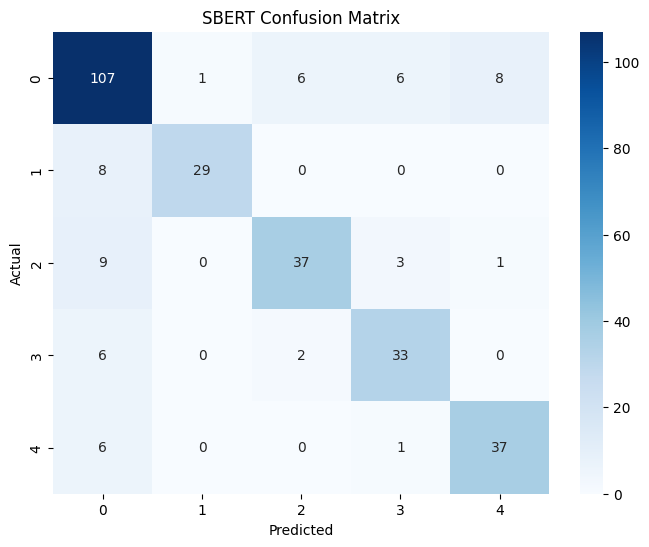

Generating BERT embeddings...

BERT Clustering Silhouette Score: 0.053543955


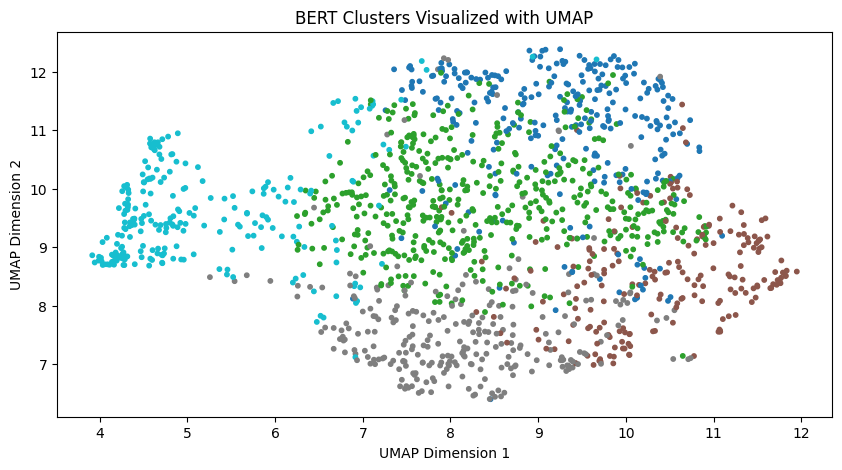


BERT Classification Report:
              precision    recall  f1-score   support

      writes       0.77      0.78      0.78       128
         god       0.78      0.78      0.78        37
      thanks       0.81      0.78      0.80        50
       space       0.85      0.83      0.84        41
        bike       0.80      0.82      0.81        44

    accuracy                           0.79       300
   macro avg       0.80      0.80      0.80       300
weighted avg       0.79      0.79      0.79       300



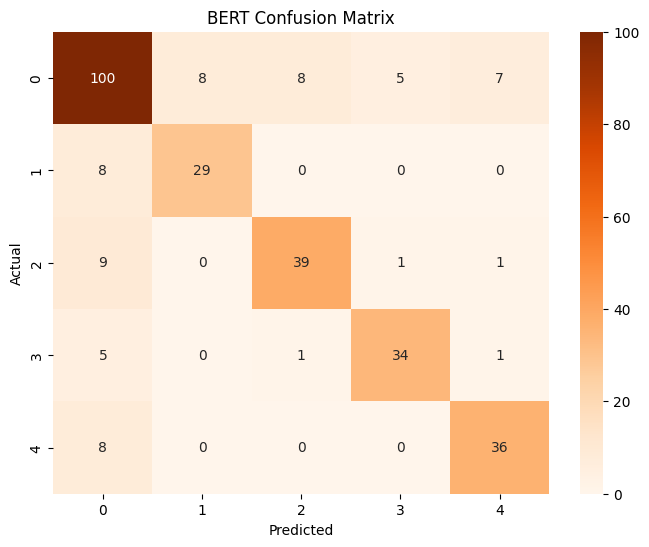


=== Saving Best Model ===
Pipeline completed. Models saved.


In [37]:
if __name__ == "__main__":
    input_text_document = "../datasets/train_data_text.pkl"
    # Run the full pipeline
    run_text_analysis_pipeline(input_text_document, n_clusters=5)

In [39]:
# Example inference
sample_docs = [
    "The moon mission was a great success by ISRO.",
    "Jesus and faith are central to Christianity and God bless all.",
    "Just got a new diary along with a gel pen from the institute.",
    "Just got a new Honda bike and it's amazing!",
    "The manner in which the new chipset sets benchmark for computing"
]

print("\n=== Example Predictions ===")
results = predict_from_text(sample_docs)
for i, (label, confidence) in enumerate(results):
    print(f"Doc {i+1}: Cluster = {label}, Confidence = {confidence}")


=== Example Predictions ===
Doc 1: Cluster = space, Confidence = 0.5281
Doc 2: Cluster = god, Confidence = 0.7196
Doc 3: Cluster = writes, Confidence = 0.716
Doc 4: Cluster = bike, Confidence = 0.7512
Doc 5: Cluster = writes, Confidence = 0.7059
